In [95]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [96]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [99]:
img_rows, img_cols = 28, 28 
num_classes = 10

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [100]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Flatten(input_shape=(28, 28)),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')
])

In [101]:
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

In [102]:
model.compile(
    loss=loss_obj,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

In [103]:
model.fit(x_train, y_train, epochs=6,)

Epoch 1/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2611 - accuracy: 0.9260
Epoch 2/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1158 - accuracy: 0.9652
Epoch 3/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0785 - accuracy: 0.9760
Epoch 4/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0611 - accuracy: 0.9813
Epoch 5/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0469 - accuracy: 0.9852
Epoch 6/6
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0366 - accuracy: 0.9887


In [104]:
def create_adversarial_example(image, label):
  """
  Create adverssarial examples with signed_grad
  
  Args:
    image: image with shape (1, 28, 28) or (batch_size, height, width)
    label: label associated with the image. Label is type integer

  Returns:
    signed_grad: return the signed gradient of the image
  """
  # convert the image into a tf.Tensor
  image = tf.convert_to_tensor(image.reshape(1, img_rows, img_cols))

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = loss_obj(label, prediction)

  # Get gradients of the loss w.r.t the input image
  gradient = tape.gradient(loss, image)
  # Get the sign of gradient to create perturbation
  signed_grad = tf.sign(gradient)

  return signed_grad

In [167]:
def show_image(image, label, confidence, description):
  plt.figure()
  plt.imshow(image * 0.5 + 0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence * 100))

In [168]:
def display_adversarial_examples(image, label, eps):
  """
  Produces len(eps) + 1 images that apply pertubations to the image.

  Args:
    image: image with shape (1, 28, 28) or (batch_size, height, width)
    label: label associated with the image. Label is type integer
    eps: array with different epsilon values that want to tested. Shape (1, n)
  """
  # contains all images after the pertubation was applied
  adversarial_images = [] 

  for ep in eps:
    # create pertubation
    perturbation = create_adversarial_example(image, label)
    # apply epsilon * the pertubation to the image
    adversarial = image + ep * perturbation
    # predict the label for the adversarial example
    adversarial_label = np.argmax(model.predict(adversarial))
    # get the confidence of the prediction
    adversarial_conf = np.amax(model.predict(adversarial))
    adversarial_images.append((adversarial, adversarial_label, adversarial_conf, 'Epsilon = {:0.3f}'.format(ep)))

  # show original
  show_image(image.reshape(img_rows, img_cols), label, np.amax(model.predict(image)), "Input")

  # generate images
  for ad_ex in adversarial_images:
    ad_ex_img = ad_ex[0][0]
    ad_ex_label = ad_ex[1]
    ad_ex_conf = ad_ex[2]
    ad_ex_description = ad_ex[3]
    show_image(ad_ex_img, ad_ex_label, ad_ex_conf, ad_ex_description)

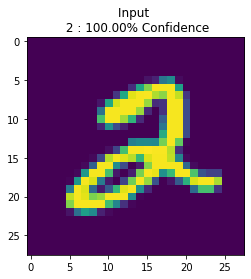

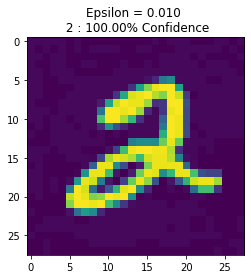

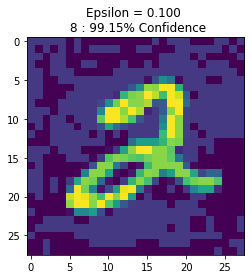

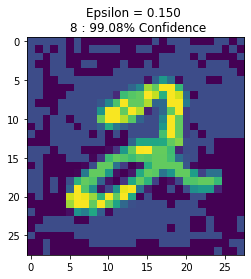

In [169]:
display_adversarial_examples(x_train[5].reshape(1, img_rows, img_cols), y_train[5], [0.01, 0.1, 0.15])